# Forewords

Notebook dedicated to the visualization of FINSURF-adjusted performance compared to other methods, using different datasets :

- the k-folds evaluation from the training
- Genomiser variants with ClinVar negative controls sampled following the sampling schemes "adjusted" (cytoband+gencode match) and "local" (distance-match)


Note that when building the tables for ROC and PRC computation, we build a dataframe where for each unique variant (positive control or negative control), the best score of each of the compared methods is retrieved from all annotated positions of this variant.

This means that a given variant will be associated to a single score from each method, but this score might actually correspond to a different scored position from one score to another (for INDEL variants.)

# Imports and definitions

In [15]:
from IPython.display import display
import time

import datetime
import importlib
import re
import multiprocessing
import yaml
import os
import sys
import pickle

import scipy.stats
import random
import gzip
import os
import sys
import tempfile


import pandas as pd
import numpy as np
import itertools as itt

In [2]:
if not '/users/ldog/moyon/Thesis/scripts/' in sys.path:
    sys.path.insert(0,'/users/ldog/moyon/Thesis/scripts/')

import dataframes
importlib.reload(dataframes)

import ML_tests
importlib.reload(ML_tests)

import ML_visualization
importlib.reload(ML_visualization)

import ML_PCA
importlib.reload(ML_PCA)

<module 'ML_PCA' from '/users/ldog/moyon/Thesis/scripts/ML_PCA.py'>

In [4]:
if not '../../createModels/' in sys.path:
    sys.path.insert(0,'../../createModels/')

from select_variants import read_indices, write_indices, memory_aware_loading, load_model_dataset

import finsurf_forest
import finsurf_treeinterpreter_nopool

import feature_contribs_lib
import create_model_lib

importlib.reload(feature_contribs_lib)
importlib.reload(finsurf_treeinterpreter_nopool)

import model_comparison_lib
importlib.reload(model_comparison_lib)

<module 'model_comparison_lib' from '../../createModels/model_comparison_lib.py'>

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
husl = sns.color_palette('husl',32)
sns.palplot(husl)
plt.close()
plt.style.use('seaborn-notebook')

SMALL_SIZE=16
MEDIUM_SIZE=20
BIGGER_SIZE=22

mpl.rc('font',size=SMALL_SIZE)
mpl.rc('axes',titlesize=SMALL_SIZE)
mpl.rc('axes',labelsize=MEDIUM_SIZE)
mpl.rc('xtick',labelsize=SMALL_SIZE)
mpl.rc('ytick',labelsize=SMALL_SIZE)
mpl.rc('legend',fontsize=SMALL_SIZE)
mpl.rc('figure',titlesize=BIGGER_SIZE)

In [49]:
import pybedtools as pbt

tmp_dir = "/localtmp/moyon/"
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

tmp_dir = tempfile.TemporaryDirectory(dir=tmp_dir).name
os.makedirs(tmp_dir)
pbt.set_tempdir(tmp_dir)

print("Temporary BedTool files will be stored in '{}'".format(tmp_dir))

Temporary BedTool files will be stored in '/localtmp/moyon/tmpnmstdfkv'


In [50]:
import sklearn_pandas
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.impute
from sklearn.externals import joblib

# FINSURF Model - load and init

## Metadata and data structure initialization

In [ ]:
hgmd_fp = "../../datasets/HGMD_variants/{}/Prefixed_4_VEP_HGMD_PRO_2017.2_hg19.tsv.gz"
hgmd_colmetadata_fp = "../../datasets/HGMD_variants/numeric/Prefixed_4_VEP_HGMD_PRO_2017.2_hg19_colMetadata.yaml"

In [6]:
# BASE COLUMNS
hgmd_colmetadata = yaml.load(open(hgmd_colmetadata_fp,'r'))
original_cols = pd.read_table(hgmd_fp.format('numeric'),nrows=3).columns.values

col_types = {c:v['distype'] for c,v in hgmd_colmetadata.items()
             if not v['distype']=='other'}

feature_colors = {c:v['color'] for c,v in hgmd_colmetadata.items()}
feature_colors['vartrans.ord'] = '#30db88' # GENOME annotation ; by default my `annotToNum` script assigns it to "OTHER".

example_dataset_train_table = '../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/datasets/X.tsv.gz'
num_cols = [c for c in pd.read_table(example_dataset_train_table,nrows=3).columns
            if c in col_types.keys()]

In [7]:
# ADDING THE GENES-ANNOTATIONS COLUMNS
if not 'ratio_shared_targets' in num_cols:
    num_cols.append('ratio_shared_targets')
    
if not 'targets_associations' in num_cols:
    num_cols.append('ratio_shared_targets')
    
# This will be used to update the metadata dict associated to the original numeric table.
targets_associations_metadata = {
    'ratio_shared_targets':{
        'category':'ENHANCERS',
        'color':'#1260e8',
        'distype':'continuous',
        'old_name':'ratio_shared_targets'
    },
    'targets_associations':{
        'category':'ENHANCERS',
        'color':'#1260e8',
        'distype':'discrete',
        'old_name':'targets_associations'
    }
}

hgmd_colmetadata.update(targets_associations_metadata)

# Regenerate the previous variables
col_types = {c:v['distype'] for c,v in hgmd_colmetadata.items() if not v['distype']=='other'}
feature_colors = {c:v['color'] for c,v in hgmd_colmetadata.items()}
feature_colors['vartrans.ord'] = '#30db88' # GENOME annotation ; by default my `annotToNum` script assigns it to "OTHER".
num_cols = [c for c in pd.read_table(example_dataset_train_table,nrows=3).columns if c in col_types.keys()]


col_cat = {c:v['category'] for c,v in hgmd_colmetadata.items() if not v['distype']=='other'}

cat_features = {}
# Maps names of categories to list of features
_ = {cat_features.setdefault(value,[]).append(key) for key, value in col_cat.items()}

# Here: correcting the category for vartrans
col_cat['vartrans.ord'] = 'GENOME'


# And finally produce the variables used for plots and training.
reduced_num_cols = [c for c in num_cols
                    if (not "mean" in c)
                        and (not "closest" in c)
                        and (not c.startswith('phyl46w'))
                        and (not c.startswith('phast46w'))
                   ]

In [8]:
path_columns = "../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/full-model_woTargs_columns.txt"
path_columns_wtargs = "../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/full-model_wTargs_columns.txt"

model_columns = [v.strip('\n') for v in open(path_columns).readlines()]
model_columns_wtargs = [v.strip('\n') for v in open(path_columns_wtargs).readlines()]

## Loading datasets

In [9]:
all_models = {'HGMD-DM':{}}
all_X_dfs = {'HGMD-DM':{}}
all_y_arrs = {'HGMD-DM':{}}
class_names = {'HGMD-DM':{}}

##### HGMD-DM - CytobandMatch

In [10]:
model_path="../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/full-model_woTargs.pkl"
model_dataset_path = "../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/datasets/"

In [11]:
%%time

X, y = load_model_dataset(model_dataset_path)
y = np.array(y)

all_X_dfs['HGMD-DM']['cytobandMatch'] = X
all_y_arrs['HGMD-DM']['cytobandMatch'] = y
class_names['HGMD-DM']['cytobandMatch'] = ['ClinVar-ctrl','HGMD-DM']

print(("Original dataset contains {:,} samples, of which {:.3}% are positive samples.\n"
      ).format(all_X_dfs['HGMD-DM']['cytobandMatch'].shape[0],
               100*all_y_arrs['HGMD-DM']['cytobandMatch'].sum()/len(all_y_arrs['HGMD-DM']['cytobandMatch'])))

Original dataset contains 67,967 samples, of which 1.29% are positive samples.

CPU times: user 1.65 s, sys: 120 ms, total: 1.77 s
Wall time: 1.77 s


In [16]:
print("{} - load HGMDDM - cytobandMatch\n".format(datetime.datetime.now().replace(microsecond=0)))
all_models['HGMD-DM']['cytobandMatch'] = joblib.load(model_path)

2021-01-27 16:16:43 - load HGMDDM - cytobandMatch



##### HGMD-DM - Distance

In [17]:
model_dataset_path = "../../models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model/datasets/"
model_path = "../../models/HGMD-DM_ClinVar-noPat_distanceMatch/training_model/full-model_woTargs.pkl"

In [18]:
%%time
X, y = load_model_dataset(model_dataset_path)
y = np.array(y)

all_X_dfs['HGMD-DM']['distanceMatch'] = X
all_y_arrs['HGMD-DM']['distanceMatch'] = y
class_names['HGMD-DM']['distanceMatch'] = ['ClinVar-ctrl','HGMD-DM']

print(("N_samples: {:,} ({:.3}% positives)\n"
        ).format(all_X_dfs['HGMD-DM']['distanceMatch'].shape[0],
                 100*all_y_arrs['HGMD-DM']['distanceMatch'].sum()/len(all_y_arrs['HGMD-DM']['distanceMatch'])))

N_samples: 6,985 (12.6% positives)

CPU times: user 184 ms, sys: 24 ms, total: 208 ms
Wall time: 210 ms


In [19]:
print("{} - load HGMDDM - Distance\n".format(datetime.datetime.now().replace(microsecond=0)))
all_models['HGMD-DM']['distanceMatch'] = joblib.load(model_path)

2021-01-27 16:16:53 - load HGMDDM - Distance



# Model comparison : load and init

## Variables

In [20]:
columns_scores = ['CADD.score',
                  'FATHMM_MKL.score',
                  'NCBoost.score',
                  'ReMM.score',
                  'eigen.score',
                  'eigen.PC_score',
                  'fitcons',
                  'linsight',
                 ]

# For colors : http://phrogz.net/css/distinct-colors.html
colors_scores = ['#998953',
                 '#4aff8c',
                 '#75bbd9',
                 '#6234b3',
                 '#d9c93f',
                 '#6eccaa',
                 '#46a8f2',
                 '#bd4aff',
                ]

score_to_color = dict(zip(columns_scores,colors_scores))
score_to_color['FINSURF_HGMD']  = '#FF0000'
score_to_color['FINSURF'] = '#FF0000'

# Comparisons on K-folds

## CytoAware woTargs noTestImb

In [35]:
# Load kfold results
kfold_scheme='CytobandAware10Folds_woTargs_notestImb'
model='HGMD-DM_ClinVar-noPat_cytobandMatch'

path_dir = ("../../models/new_HGMD-DM/{model}/training_model/kfolds_evaluations/{kfold_scheme}/"
           ).format(model=model,kfold_scheme=kfold_scheme)

scored_df_path = ("../../models/new_HGMD-DM/{model}/training_model/datasets/num_scored_X.tsv.gz"
                 ).format(model=model)

  
outputdir_eval = ("../../models/new_HGMD-DM/{model}/training_model/new_model_comparison/"
                 ).format(model=model)

try:
    kfold_res = create_model_lib.KfoldResults(name="HGMDDM",
                                              path=path_dir)

    kf_res_list = list(kfold_res.get_kfold_res_structure())
    
    scored_df = pd.read_table(scored_df_path)
    
except Exception as e:
    print("ERROR for {model} - {kfold_scheme}".format(model=model, kfold_scheme=kfold_scheme))
    raise(e)

Loading all kfolds results from "../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/kfolds_evaluations/CytobandAware10Folds_woTargs_notestImb/"


In [36]:
# compute ROC and PRC
(models_comp_rocs,
models_comp_roc_aucs,
models_comp_prcs,
models_comp_prc_aucs) = model_comparison_lib.compute_PRC_ROC_coordAndAUCS_kfolds(
                                        kfold_res,
                                        scored_df,
                                        columns_scores)

0
	Removing 52.372505543237246% of 4,510 samples
	Percentage of positive samples: 6.657355679702048%


1
	Removing 65.97059186951687% of 8,093 samples
	Percentage of positive samples: 1.270878721859114%


2
	Removing 54.57996369037795% of 6,059 samples
	Percentage of positive samples: 1.6351744186046513%


3
	Removing 58.934243030231734% of 8,501 samples
	Percentage of positive samples: 0.8307075336579777%


4
	Removing 62.847725774555045% of 7,585 samples
	Percentage of positive samples: 2.2711142654364798%


5
	Removing 63.38562316841924% of 5,801 samples
	Percentage of positive samples: 2.0715630885122414%


6
	Removing 59.675480769230774% of 4,992 samples
	Percentage of positive samples: 1.9374068554396422%


7
	Removing 44.6060606060606% of 7,425 samples
	Percentage of positive samples: 0.9968392900559203%


8
	Removing 51.14209827357238% of 7,530 samples
	Percentage of positive samples: 1.4949714596357706%


9
	Removing 44.184178824789186% of 7,471 samples
	Percentage of positive

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


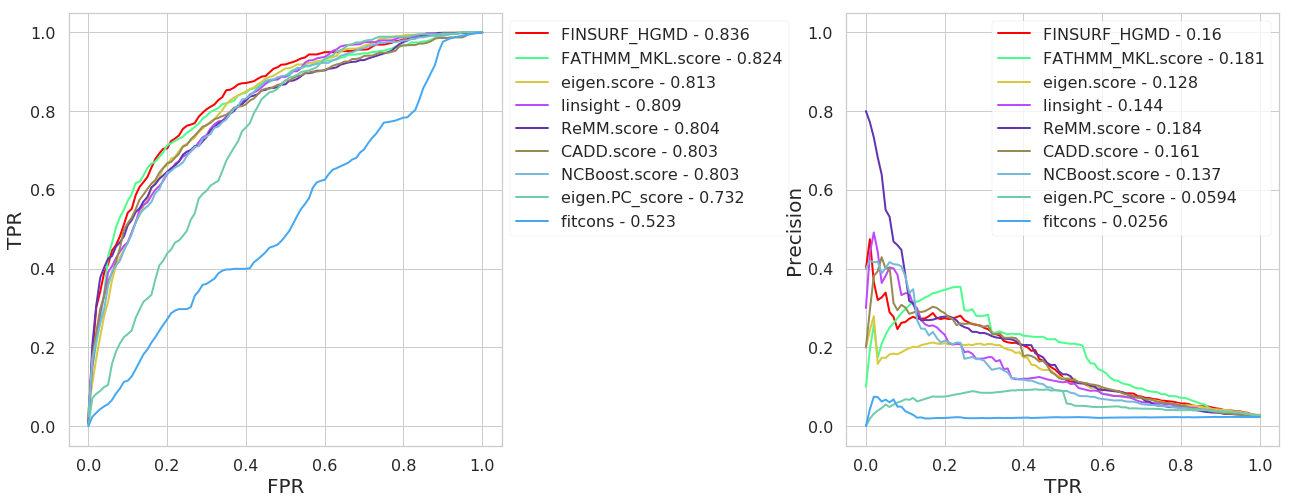

In [37]:
# Figure
path_figure=None
#path_figure = outputdir_eval+'kfolds_eval_{kfold_scheme}_model-comparison-plot.svg'.format(kfold_scheme=kfold_scheme)
model_comparison_lib.plot_comparison_rocsAndPRCs(models_comp_rocs,
                                                models_comp_roc_aucs,
                                                models_comp_prcs,
                                                models_comp_prc_aucs,
                                                score_to_color,
                                                show_plot=True,
                                                savefig_file=path_figure)

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


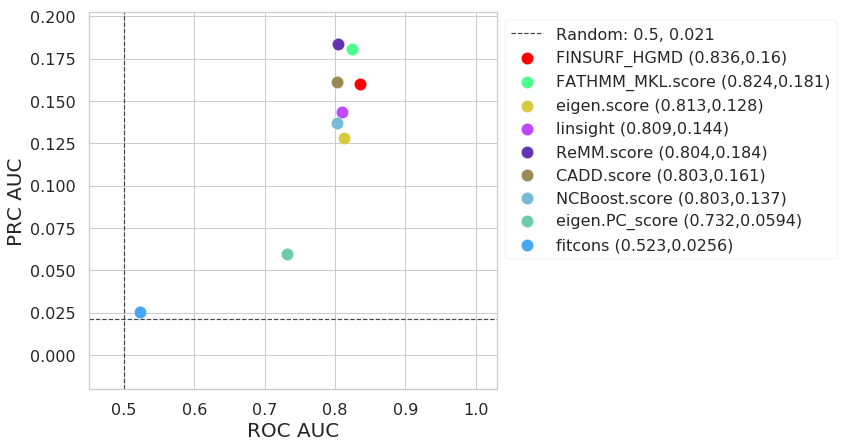

In [38]:
model_comparison_lib.scatterplot_aucs(models_comp_prc_aucs, models_comp_roc_aucs,
                                     score_to_color,
                                      y_true_proportion=0.021,
                                      sort_by='roc',
                                     full_range_roc=False,
                                     full_range_prc=False,
                                     show_plot=True,
                                     savefig_file=None
                                     )

## CytoAware woTargs testImb 12.5

In [39]:
kfold_scheme='CytobandAware10Folds_woTargs_testImb12.5'
model='HGMD-DM_ClinVar-noPat_cytobandMatch'

path_dir = ("../../models/new_HGMD-DM/{model}/training_model/kfolds_evaluations/{kfold_scheme}/"
           ).format(model=model,kfold_scheme=kfold_scheme)

scored_df_path = ("../../models/new_HGMD-DM/{model}/training_model/datasets/num_scored_X.tsv.gz"
                 ).format(model=model)

  
outputdir_eval = ("../../models/new_HGMD-DM/{model}/training_model/new_model_comparison/"
                 ).format(model=model)
try:
    kfold_res = create_model_lib.KfoldResults(name="HGMDDM",
                                              path=path_dir)

    kf_res_list = list(kfold_res.get_kfold_res_structure())
    
    scored_df = pd.read_table(scored_df_path)
    
except Exception as e:
    print("ERROR for {model} - {kfold_scheme}".format(model=model, kfold_scheme=kfold_scheme))
    raise(e)

Loading all kfolds results from "../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/kfolds_evaluations/CytobandAware10Folds_woTargs_testImb12.5/"


In [40]:
(models_comp_rocs,
models_comp_roc_aucs,
models_comp_prcs,
models_comp_prc_aucs) = model_comparison_lib.compute_PRC_ROC_coordAndAUCS_kfolds(
                                        kfold_res,
                                        scored_df,
                                        columns_scores)

0
	Removing 45.67901234567901% of 567 samples
	Percentage of positive samples: 17.20779220779221%


1
	Removing 52.991452991452995% of 585 samples
	Percentage of positive samples: 12.0%


2
	Removing 42.79835390946502% of 486 samples
	Percentage of positive samples: 15.107913669064748%


3
	Removing 61.904761904761905% of 1,071 samples
	Percentage of positive samples: 13.23529411764706%


4
	Removing 42.1875% of 576 samples
	Percentage of positive samples: 15.615615615615615%


5
	Removing 50.282485875706215% of 531 samples
	Percentage of positive samples: 13.257575757575758%


6
	Removing 54.51638689048761% of 1,251 samples
	Percentage of positive samples: 10.369068541300527%


7
	Removing 68.21705426356588% of 774 samples
	Percentage of positive samples: 12.195121951219512%


8
	Removing 47.928994082840234% of 1,521 samples
	Percentage of positive samples: 19.318181818181817%


9
	Removing 62.59259259259259% of 540 samples
	Percentage of positive samples: 24.257425742574256%


Mean p

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


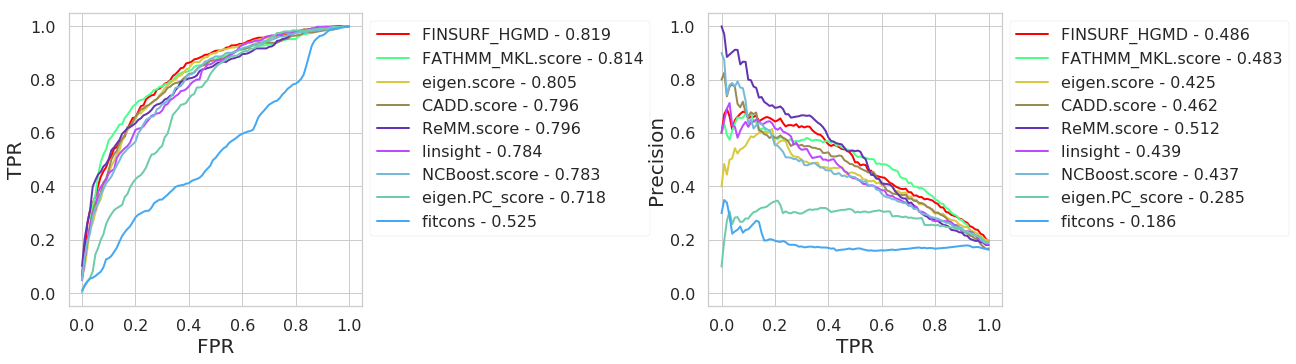

In [41]:
# Figure
path_figure=None
#path_figure = outputdir_eval+'kfolds_eval_{kfold_scheme}_model-comparison-plot.svg'.format(kfold_scheme=kfold_scheme)
model_comparison_lib.plot_comparison_rocsAndPRCs(models_comp_rocs,
                                models_comp_roc_aucs,
                                models_comp_prcs,
                                models_comp_prc_aucs,
                                score_to_color,
                                show_plot=True,
                                savefig_file=path_figure)

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


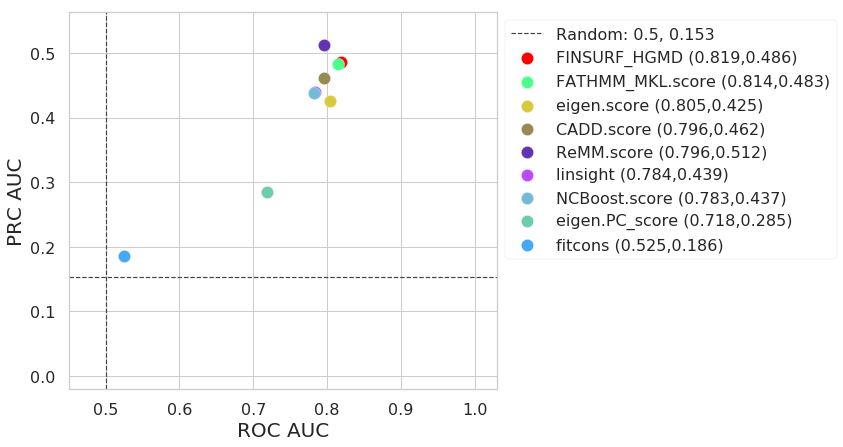

In [42]:
model_comparison_lib.scatterplot_aucs(models_comp_prc_aucs, models_comp_roc_aucs,
                                     score_to_color,
                                      y_true_proportion=0.153,
                                      sort_by='roc',
                                     full_range_roc=False,
                                     full_range_prc=False,
                                     show_plot=True,
                                     savefig_file=None
                                     )

# Genomizer and ClinVar controls

Here we use the `select_variants.py` script to generate the ClinVar sets:


```
# Example : retrieve negative controls variants applying the "distance match" 
~/Thesis/projects/FINSURF/createModels/select_variants.py  \
    --numvar_paths ./NUM_Genomizer_nc_notin_finsurf.tsv.gz ~/Thesis/RegulationData/hg19/variants/clinvar_noImpact/numeric/{}.tsv.gz \
    --names genomizer clinvar 
    --rowid_filters_paths "" "" 
    --filter_types "" ""
    --ref genomizer
    -m distanceMatch 
    -d 1000 -o ./ 
    --ncores 4
```

This is done both for the "Local" matching (distance match), and for the "Adjusted" matching (match on cytobands, then correct GENCODE biotype proportions)

## Genomizer and ClinVar controls : adjusted match

### Prepare datasets

In [43]:
# IMPORTANT : THIS WILL BE THE OUTPUT PATH FOR THE RESULTS.
path_genomizer_vs_clinvar = '../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/new_model_comparison/genomiser_vs_clinvar/'
if not os.path.exists(path_genomizer_vs_clinvar):
    os.makedirs(path_genomizer_vs_clinvar)

In [44]:
# Export the numeric table of genomizer variants NOT IN HGMD, NOT CODING
if os.path.exists(path_genomizer_vs_clinvar+"/NUM_Genomizer_nc_notin_finsurf.tsv.gz"):
    print('FILE EXISTS')
    
else:
    numeric_genomizer.loc[numeric_genomizer['row_id'].isin(vcf_genomizer_notin_finsurf['row_id'].values),:
                     ].to_csv(path_genomizer_vs_clinvar+"/NUM_Genomizer_nc_notin_finsurf.tsv.gz",
                              header=True,index=False,sep="\t", compression="gzip")

FILE EXISTS


In [45]:
genom_clinvar_Xtables = {}
genom_clinvar_ytables = {}

#### Genomiser : positive+negative with "Adjusted match"

In [ ]:
path = "/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/new_model_comparison/genomiser_vs_clinvar/ClinVar_cytobandMatch/gencodeMatch/training_model/datasets/"
genom_clinvar_Xtables["cytoband+gencode"] = pd.read_csv(path+"X.tsv.gz", header=0, sep="\t")
genom_clinvar_ytables["cytoband+gencode"] = pd.read_csv(path+"y.tsv", header=None, sep="\t").iloc[:,0].values

In [ ]:
print("N positive : {:,}".format(
        genom_clinvar_Xtables["cytoband+gencode"].loc[
            genom_clinvar_ytables["cytoband+gencode"].astype(bool),
            ['row_id']].drop_duplicates().shape[0]
))
print("N negative : {:,}".format(
        genom_clinvar_Xtables["cytoband+gencode"].loc[
            ~genom_clinvar_ytables["cytoband+gencode"].astype(bool),
            ['row_id']].drop_duplicates().shape[0]
))

N positive : 92
N negative : 36,063


Don't forget to remove the ClinVar samples that were also sampled during the training of FINSURF, to avoid over-performance of FINSURF on these already-seen negative controls

#### Filter out ClinVars that were used in training of HGMD-DM

In [51]:
bt_clin_hgmd = pbt.BedTool.from_dataframe(
                all_X_dfs['HGMD-DM']['cytobandMatch'].loc[
                    ~all_y_arrs['HGMD-DM']['cytobandMatch'].astype(bool),
                    ["chrom","start","end","row_id"]]
               )

bt_clin_genom = pbt.BedTool.from_dataframe(
                    genom_clinvar_Xtables["cytoband+gencode"].loc[
                        ~genom_clinvar_ytables["cytoband+gencode"].astype(bool),
                    ["chrom","start","end","row_id"]]
                )

intersect_clinvar_genomVShgmd = bt_clin_genom.intersect(bt_clin_hgmd,wao=True).to_dataframe()
rowids_clinvarGenom_NOT_overlapping_clinvarHGMD = intersect_clinvar_genomVShgmd.loc[intersect_clinvar_genomVShgmd["score"]==".","name"].unique()

In [52]:
# Finale table : 

# First : get the ClinVar NOT in FINSURF training set
reassembled_genomClinvar_X = genom_clinvar_Xtables["cytoband+gencode"].loc[
                                ~genom_clinvar_ytables["cytoband+gencode"].astype(bool),
                             :].loc[lambda df: df['row_id'].isin(rowids_clinvarGenom_NOT_overlapping_clinvarHGMD),:]

# Then : concatenate the positive controls
reassembled_genomClinvar_X = pd.concat([
                                reassembled_genomClinvar_X,
                                genom_clinvar_Xtables["cytoband+gencode"].loc[
                                    genom_clinvar_ytables["cytoband+gencode"].astype(bool),:]],
                              axis=0)

# Sort index, BUT DO NOT RESET IT : we will be using it to locate rows
# from tables indexed with the "full" set of ClinVar
# e.g below with the y labels, and next section : scores from other methods
reassembled_genomClinvar_X.sort_index()


reassembled_genomClinvar_y = genom_clinvar_ytables["cytoband+gencode"][reassembled_genomClinvar_X.index.values]

#### Get predictions by FINSURF and other models

First load the tables of scores by other models, and predict with FINSURF model

In [53]:
# Get the predictions, and load the score annotations

predGenomClinvar = all_models['HGMD-DM']["cytobandMatch"].predict_proba(
                        reassembled_genomClinvar_X.loc[:,model_columns]
                    )[:,1]

scored_GenomClinvar = pd.read_csv(path+'scored/NUM_scored_X.tsv.gz', header=0, sep="\t"
                                 ).loc[reassembled_genomClinvar_X.index.values,:]
scored_GenomClinvar['FINSURF'] = predGenomClinvar

We will associate each variant to its best score, for each method.

In [54]:
# Here : separate positive and negatives ; associate each variant to a unique score for each method (based on the best score position)
tmp_pos = scored_GenomClinvar.loc[reassembled_genomClinvar_y==1,['row_id','FINSURF']+columns_scores]
tmp_neg = scored_GenomClinvar.loc[reassembled_genomClinvar_y==0,['row_id','FINSURF']+columns_scores]

In [55]:
# Positive variants : keep best score among scored position, for each model

# First : best score per variant using FINSURF score.
tmp_pos_dropdup = tmp_pos.sort_values(by=['row_id','FINSURF'],
                                      ascending=[True,False]
                                     ).drop_duplicates(
                    subset='row_id', keep='first'
                  ).loc[:,['row_id','FINSURF']]
# Then : best score per variant for each other score.
# The de-duplicated scores are merged to the table with the FINSURF score
# created above.
for model_col in columns_scores:
    tmp_model_col = tmp_pos.loc[:,['row_id',model_col]
                               ].sort_values(by=['row_id',model_col],
                                             ascending=[True,False]
                                            ).drop_duplicates(subset='row_id',
                                                              keep='first')
    
    tmp_pos_dropdup = pd.merge(tmp_pos_dropdup, tmp_model_col,
                               left_on='row_id',
                               right_on='row_id',
                               how='left'
                               )
  

In [56]:
# Negative variants : keep best score among scored position, for each model

# First : best score per variant using FINSURF score.
tmp_neg_dropdup = tmp_neg.sort_values(by=['row_id','FINSURF'],
                                      ascending=[True,False]
                                     ).drop_duplicates(
                    subset='row_id', keep='first'
                  ).loc[:,['row_id','FINSURF']]


for model_col in columns_scores:
    tmp_model_col = tmp_neg.loc[:,['row_id',model_col]
                               ].sort_values(by=['row_id',model_col],
                                             ascending=[True,False]
                                             ).drop_duplicates(subset='row_id',
                                                               keep='first')
    
    tmp_neg_dropdup = pd.merge(tmp_neg_dropdup, tmp_model_col,
                               left_on='row_id',
                               right_on='row_id',
                               how='left'
                               )

#### Numbers

We want to check the number of variant types for positives and for negatives.

In [57]:
print("Number of positives, unique scored position per variant:")

tmp = genom_clinvar_Xtables["cytoband+gencode"].loc[
                    genom_clinvar_ytables["cytoband+gencode"]==1,
                    :].loc[
                lambda df: df['row_id'].isin(tmp_pos_dropdup['row_id'].values),
                :].drop_duplicates(subset='row_id')

display(tmp['vartype'].value_counts())
print("Total = {:,}".format(tmp.shape[0]))

print("\n")
print("Same, after filter-out of variants missing a score from any method:")

tmp = genom_clinvar_Xtables["cytoband+gencode"].loc[
                        genom_clinvar_ytables["cytoband+gencode"]==1,:
                        ].loc[
                     lambda df: df['row_id'].isin(
                         tmp_pos_dropdup.loc[tmp_pos_dropdup.isna().sum(axis=1)==0,'row_id'].values
                         ),:].drop_duplicates(subset='row_id')

display(tmp['vartype'].value_counts())
print("Total = {:,}".format(tmp.shape[0]))

Number of positives, unique scored position per variant:


SNV      64
DEL      18
INS       7
INDEL     3
Name: vartype, dtype: int64

Total = 92


Same, after filter-out of variants missing a score from any method:


SNV      41
DEL      13
INS       5
INDEL     3
Name: vartype, dtype: int64

Total = 62


Do the same with negatives.

In [58]:
print("Number of negatives, unique scored position per variant:")

tmp = genom_clinvar_Xtables["cytoband+gencode"].loc[
        genom_clinvar_ytables["cytoband+gencode"]==0,
        :].loc[lambda df: df['row_id'].isin(tmp_neg_dropdup['row_id'].values),
               :].drop_duplicates(subset='row_id')

display(tmp['vartype'].value_counts())

print("Total = {:,}".format(tmp.shape[0]))

print("\n")
print("Same, after filter-out of variants missing a score from any method:")

tmp = genom_clinvar_Xtables["cytoband+gencode"].loc[
        genom_clinvar_ytables["cytoband+gencode"]==0,
        :].loc[lambda df: df['row_id'].isin(tmp_neg_dropdup.loc[tmp_neg_dropdup.isna().sum(axis=1)==0,'row_id'].values),
               :].drop_duplicates(subset='row_id')


display(tmp['vartype'].value_counts())

print("Total = {:,}".format(tmp.shape[0]))

Number of negatives, unique scored position per variant:


SNV      20859
INS       5399
DEL       5298
INDEL        8
Name: vartype, dtype: int64

Total = 31,564


Same, after filter-out of variants missing a score from any method:


SNV      11374
INS       3059
DEL       2685
INDEL        4
Name: vartype, dtype: int64

Total = 17,122


#### Assemble the finale tables and export

In [59]:
path_finsurf_eval = "../../models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/new_model_comparison/genomiser_vs_clinvar/ClinVar_cytobandMatch/gencodeMatch/training_model/FINSURF_EVAL/"
if not os.path.exists(path_finsurf_eval):
    os.makedirs(path_finsurf_eval)

In [60]:
tmp_table_genomClinvar = pd.concat([tmp_pos_dropdup,
                                    tmp_neg_dropdup], axis=0
                                  ).reset_index(drop=True)

tmp_table_genomClinvar_nona = tmp_table_genomClinvar.loc[
                                tmp_table_genomClinvar.isna().sum(axis=1)==0,
                                :]

print("Number of variants: {:,}".format(tmp_table_genomClinvar.shape[0]))
print("Number of variants with scores from all methods (no NA): {:,}".format(tmp_table_genomClinvar_nona.shape[0]))

Number of variants: 31,656
Number of variants with scores from all methods (no NA): 17,184


In [61]:
tmp_table_export = pd.concat([tmp_pos, tmp_neg], axis=0)

tmp_table_export['y_true'] = [1 for _ in range(tmp_pos.shape[0])]+\
                             [0 for _ in range(tmp_neg.shape[0])]

In [ ]:
tmp_table_export.to_csv(path_finsurf_eval+'scored_genomizerNoFINSURF+ClinVar_cytoMatch+GENCODEmatch_withNa.tsv.gz',
                        header=True, index=False, sep="\t", compression="gzip")

A better table to export is the `tmp_table_genomClinvar_nona` or `tmp_table_genomClinvar`

### ROC and AUCs

In [63]:
tmp_X = tmp_table_genomClinvar_nona
tmp_y = np.array([1 for _ in range(tmp_pos_dropdup.shape[0])] + \
                 [0 for _ in range(tmp_neg_dropdup.shape[0])]
                )[tmp_table_genomClinvar_nona.index.values]


(models_comp_rocs,
 models_comp_roc_aucs,
 models_comp_prcs,
 models_comp_prc_aucs) = model_comparison_lib.compute_PRC_ROC_coordAndAUCS_single(
                                                             tmp_X,
                                                             tmp_y, 
                                                             columns_scores+['FINSURF'])

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


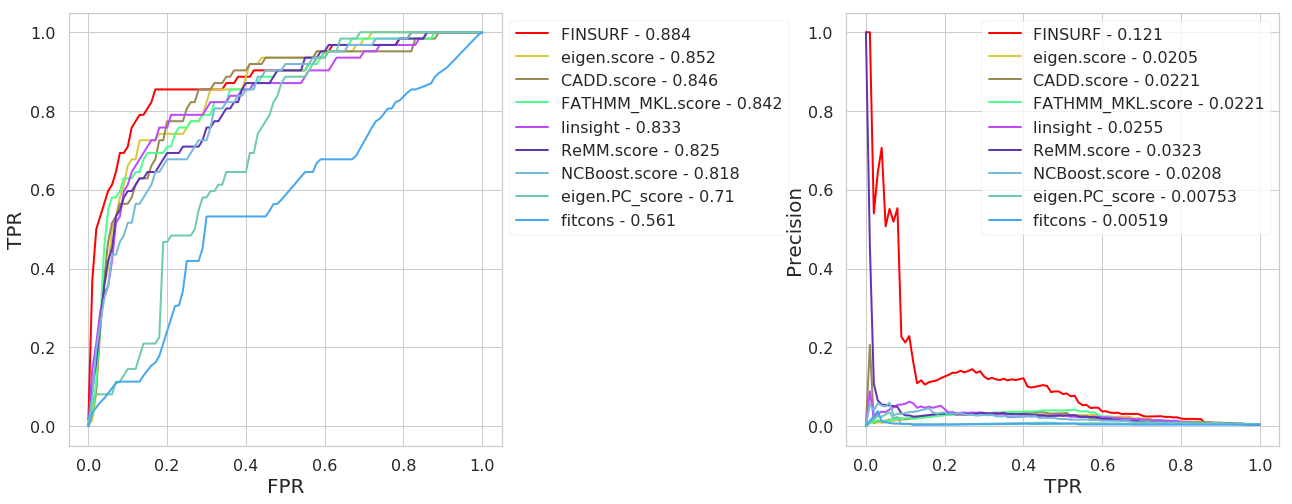

In [64]:
path_figure=None
#path_figure = path_finsurf_eval+'ROC-and-PRC_genomizer+ClinVar_cytoMatch+GENCODEmatch.svg'
model_comparison_lib.plot_comparison_rocsAndPRCs(models_comp_rocs, models_comp_roc_aucs,
                            models_comp_prcs, models_comp_prc_aucs,
                            score_to_color,
                            savefig_file=path_figure)

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


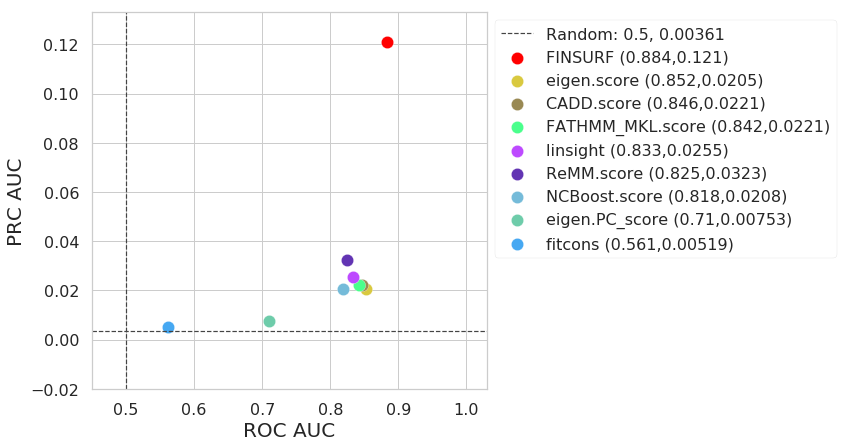

In [68]:
model_comparison_lib.scatterplot_aucs(models_comp_prc_aucs, models_comp_roc_aucs,
                                     score_to_color,
                                      y_true = np.array(tmp_y),
                                      sort_by='roc',
                                     full_range_roc=False,
                                     full_range_prc=False,
                                     show_plot=True,
                                     savefig_file=None
                                     )

## Genomizer and ClinVar controls : distance match

Same analysis, but with ClinVar controls sampled according to the "local match" scheme (distance match, max 1kb from a positive).

In [69]:
path = "/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/new_model_comparison/genomiser_vs_clinvar/ClinVar_distanceMatch/training_model/datasets/"
genom_clinvar_Xtables["distance"] = pd.read_csv(path+"X.tsv.gz", header=0, sep="\t")
genom_clinvar_ytables["distance"] = pd.read_csv(path+"y.tsv", header=None, sep="\t").iloc[:,0].values

In [70]:
bt_clin_hgmd = pbt.BedTool.from_dataframe(all_X_dfs['HGMD-DM']['cytobandMatch'].loc[~all_y_arrs['HGMD-DM']['cytobandMatch'].astype(bool),
                                                                                   ["chrom","start","end","row_id"]])
bt_clin_genom = pbt.BedTool.from_dataframe(genom_clinvar_Xtables["distance"].loc[~genom_clinvar_ytables["distance"].astype(bool),
                                                               ["chrom","start","end","row_id"]])
intersect_clinvar_genomVShgmd = bt_clin_genom.intersect(bt_clin_hgmd,wao=True).to_dataframe()
rowids_clinvarGenom_NOT_overlapping_clinvarHGMD = intersect_clinvar_genomVShgmd.loc[intersect_clinvar_genomVShgmd["score"]==".","name"].unique()

In [71]:
reassembled_genomClinvar_X = genom_clinvar_Xtables["distance"].loc[~genom_clinvar_ytables["distance"].astype(bool),
                                                                    :].loc[lambda df: df['row_id'].isin(rowids_clinvarGenom_NOT_overlapping_clinvarHGMD),:]

reassembled_genomClinvar_X = pd.concat([reassembled_genomClinvar_X,
                                 genom_clinvar_Xtables["distance"].loc[genom_clinvar_ytables["distance"].astype(bool),:]],
                                axis=0)

reassembled_genomClinvar_X.sort_index()

reassembled_genomClinvar_y = genom_clinvar_ytables["distance"][reassembled_genomClinvar_X.index.values]

In [72]:
# Get the predictions, and load the score annotations

predGenomClinvar = all_models['HGMD-DM']["cytobandMatch"].predict_proba(reassembled_genomClinvar_X.loc[:,model_columns])[:,1]

scored_GenomClinvar = pd.read_csv(path+'scored/NUM_scored_X.tsv.gz', header=0, sep="\t").loc[reassembled_genomClinvar_X.index.values,:]
scored_GenomClinvar['FINSURF'] = predGenomClinvar

In [73]:
tmp_pos = scored_GenomClinvar.loc[reassembled_genomClinvar_y==1,['row_id','FINSURF']+columns_scores]

tmp_pos_dropdup = tmp_pos.sort_values(by=['row_id','FINSURF'],
                                      ascending=[True,False]
                                     ).drop_duplicates(subset='row_id', keep='first').loc[:,['row_id','FINSURF']]

for model_col in columns_scores:
    tmp_model_col = tmp_pos.loc[:,['row_id',model_col]
                                             ].sort_values(by=['row_id',model_col],
                                                           ascending=[True,False]
                                                          ).drop_duplicates(subset='row_id',
                                                                            keep='first')
    
    tmp_pos_dropdup = pd.merge(tmp_pos_dropdup, tmp_model_col,
                                   left_on='row_id',
                                   right_on='row_id',
                                   how='left'
                                  )

In [74]:
tmp_neg = scored_GenomClinvar.loc[reassembled_genomClinvar_y==0,['row_id','FINSURF']+columns_scores]

tmp_neg_dropdup = tmp_neg.sort_values(by=['row_id','FINSURF'],
                                      ascending=[True,False]
                                     ).drop_duplicates(subset='row_id', keep='first').loc[:,['row_id','FINSURF']]

for model_col in columns_scores:
    tmp_model_col = tmp_neg.loc[:,['row_id',model_col]
                                             ].sort_values(by=['row_id',model_col],
                                                           ascending=[True,False]
                                                          ).drop_duplicates(subset='row_id',
                                                                            keep='first')
    
    tmp_neg_dropdup = pd.merge(tmp_neg_dropdup, tmp_model_col,
                                   left_on='row_id',
                                   right_on='row_id',
                                   how='left'
                                  )

In [75]:
tmp_table_genomClinvar = pd.concat([tmp_pos_dropdup, tmp_neg_dropdup]).reset_index(drop=True)
tmp_table_genomClinvar_nona = tmp_table_genomClinvar.loc[tmp_table_genomClinvar.isna().sum(axis=1)==0,:]

print("Number of variants: {:,}".format(tmp_table_genomClinvar.shape[0]))
print("Number of variants with scores from all methods (no NA): {:,}".format(tmp_table_genomClinvar_nona.shape[0]))

Number of variants: 1,186
Number of variants with scores from all methods (no NA): 727


In [76]:
path_finsurf_eval = "/import/kg_dyows05/moyon/Thesis/projects/FINSURF/models/new_HGMD-DM/HGMD-DM_ClinVar-noPat_cytobandMatch/training_model/new_model_comparison/genomiser_vs_clinvar/ClinVar_distanceMatch/training_model/FINSURF_EVAL/"
if not os.path.exists(path_finsurf_eval):
    os.makedirs(path_finsurf_eval)

tmp_table_export = pd.concat([tmp_pos,tmp_neg
                              ], axis=0)

tmp_table_export['y_true'] = [1 for _ in range(tmp_pos.shape[0])]+\
                             [0 for _ in range(tmp_neg.shape[0])]

In [ ]:
tmp_table_export.to_csv(path_finsurf_eval+'scored_genomizerNoFINSURF+ClinVar_cytoMatch+GENCODEmatch_withNa.tsv.gz',
                        header=True, index=False, sep="\t", compression="gzip")

In [78]:
tmp_X = tmp_table_genomClinvar_nona
tmp_y = np.array([1 for _ in range(tmp_pos_dropdup.shape[0])] + \
                 [0 for _ in range(tmp_neg_dropdup.shape[0])]
                )[tmp_table_genomClinvar_nona.index.values]


(models_comp_rocs,
 models_comp_roc_aucs,
 models_comp_prcs,
 models_comp_prc_aucs) = model_comparison_lib.compute_PRC_ROC_coordAndAUCS_single(
                                                             tmp_X,
                                                             tmp_y, 
                                                             columns_scores+['FINSURF'])

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


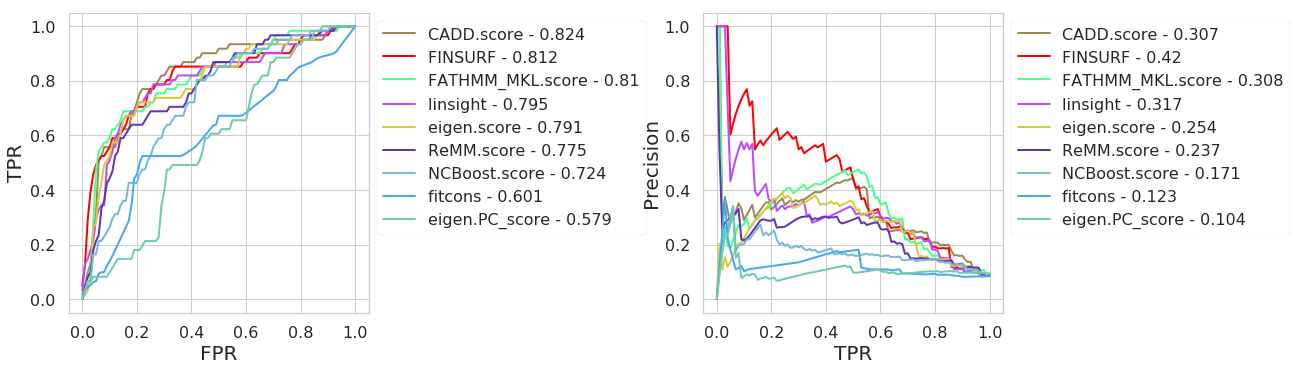

In [79]:
path_figure = None
#path_figure=path_finsurf_eval+'ROC-and-PRC_genomizer+ClinVar_cytoMatch+GENCODEmatch.svg'

model_comparison_lib.plot_comparison_rocsAndPRCs(models_comp_rocs, models_comp_roc_aucs,
                                                models_comp_prcs, models_comp_prc_aucs,
                                                score_to_color,
                                                savefig_file=path_figure)

/users/ldog/moyon/anaconda3/envs/finsurf_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


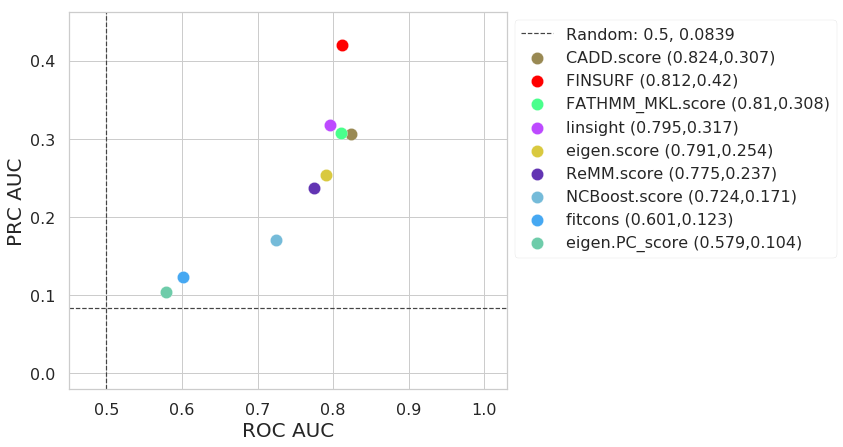

In [81]:
model_comparison_lib.scatterplot_aucs(models_comp_prc_aucs, models_comp_roc_aucs,
                                     score_to_color,
                                      y_true=np.array(tmp_y),
                                      sort_by='roc',
                                     full_range_roc=False,
                                     full_range_prc=False,
                                     show_plot=True,
                                     savefig_file=None
                                     )